In [1]:
import cv2
import h5py
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
import matplotlib.animation as animation
from collections import OrderedDict

In [2]:
def time_from_start(end_time):
    t_step = end_time.replace(tzinfo=None)  - moves_df.start_time[0].replace(tzinfo=None) 
    frame_number = t_step.total_seconds()
    return frame_number

In [3]:
def rounded_rectangle(src, top_left, bottom_right, radius=1, color=255, thickness=1, line_type=cv2.LINE_AA):

    #  corners:
    #  p1 - p2
    #  |     |
    #  p4 - p3

    p1 = top_left
    p2 = (bottom_right[1], top_left[1])
    p3 = (bottom_right[1], bottom_right[0])
    p4 = (top_left[0], bottom_right[0])

    height = abs(bottom_right[0] - top_left[1])

    if radius > 1:
        radius = 1

    corner_radius = int(radius * (height/2))

    if thickness < 0:

        #big rect
        top_left_main_rect = (int(p1[0] + corner_radius), int(p1[1]))
        bottom_right_main_rect = (int(p3[0] - corner_radius), int(p3[1]))

        top_left_rect_left = (p1[0], p1[1] + corner_radius)
        bottom_right_rect_left = (p4[0] + corner_radius, p4[1] - corner_radius)

        top_left_rect_right = (p2[0] - corner_radius, p2[1] + corner_radius)
        bottom_right_rect_right = (p3[0], p3[1] - corner_radius)

        all_rects = [
        [top_left_main_rect, bottom_right_main_rect], 
        [top_left_rect_left, bottom_right_rect_left], 
        [top_left_rect_right, bottom_right_rect_right]]

        [cv2.rectangle(src, rect[0], rect[1], color, thickness) for rect in all_rects]

    # draw straight lines
    cv2.line(src, (p1[0] + corner_radius, p1[1]), (p2[0] - corner_radius, p2[1]), color, abs(thickness), line_type)
    cv2.line(src, (p2[0], p2[1] + corner_radius), (p3[0], p3[1] - corner_radius), color, abs(thickness), line_type)
    cv2.line(src, (p3[0] - corner_radius, p4[1]), (p4[0] + corner_radius, p3[1]), color, abs(thickness), line_type)
    cv2.line(src, (p4[0], p4[1] - corner_radius), (p1[0], p1[1] + corner_radius), color, abs(thickness), line_type)

    # draw arcs
    cv2.ellipse(src, (p1[0] + corner_radius, p1[1] + corner_radius), (corner_radius, corner_radius), 180.0, 0, 90, color ,thickness, line_type)
    cv2.ellipse(src, (p2[0] - corner_radius, p2[1] + corner_radius), (corner_radius, corner_radius), 270.0, 0, 90, color , thickness, line_type)
    cv2.ellipse(src, (p3[0] - corner_radius, p3[1] - corner_radius), (corner_radius, corner_radius), 0.0, 0, 90,   color , thickness, line_type)
    cv2.ellipse(src, (p4[0] + corner_radius, p4[1] - corner_radius), (corner_radius, corner_radius), 90.0, 0, 90,  color , thickness, line_type)

    return src

In [4]:
# Load Video and stats
cap = cv2.VideoCapture('./data/overhang/Overhang.mp4')
ret, frame = cap.read()
cv2.imshow('frame', frame)
fps = cap.get(cv2.cv2.CAP_PROP_FPS)
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [5]:
# Load and preprocess moves data corresponding to video
moves_df = pd.read_csv("./data/overhang/overhang_moves.csv")
moves_df[['start_time', 'end_time']] = moves_df[['start_time', 'end_time']].apply(pd.to_datetime)
moves_df['time_from_start'] = moves_df['end_time'].apply(time_from_start)

In [6]:
# Load and preprocess moves data corresponding to video
h5_file_name = './data/overhang/overhang.h5'
f = h5py.File(h5_file_name, 'r')
height_profile = f['climbs/0/height_profile']

In [7]:
def addStats(time, frame):
    query_df = moves_df[moves_df['time_from_start'] <= time]
    if query_df.shape[0] != 0:
        cv2.putText(frame, "Total Moves {}".format(query_df.move_index.max()),
                                                   (10, 20), cv2.FONT_HERSHEY_SIMPLEX,
                                                   0.5, (255, 255, 255), 1)

    cv2.putText(frame, "Total time on hold:", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    left_hold = query_df[query_df['hand'] == 'left']
    right_hold = query_df[query_df['hand'] == 'right']
    if left_hold.shape[0] != 0 and right_hold.shape[0] != 0:
        cv2.putText(frame, f"L: {round(left_hold.on_hold.sum(), 2)} seconds",
                    (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.putText(frame, f"R: {round(right_hold.on_hold.sum(), 2)} seconds",
                    (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

In [12]:
h5_file_name = './data/overhang/overhang.h5'
f = h5py.File(h5_file_name, 'r')
height_profile = f['climbs/0/height_profile']
max_height = max(height_profile)
max_height_index = np.argmax(height_profile, axis=0)
len_height = len(height_profile)
rocket = Image.open('../rocket.png')
rocket = rocket.resize((50,50))

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

def rocketGraphFunc(time, frame, add_rocket):
    if time > len_height / 10:
        time = len_height / 10
    plt.clf()
    ## for '/climbs/0/height_profile' we are sampling at 10Hz, i.e. every 0.1s
    #ind = min(math.floor(time/0.1), len_height - 1) # stay in bounds

    nr_readings = min(math.floor(time/0.1), max_height_index - 1)
    if nr_readings == 0:
        return frame
    
    x = range(nr_readings)
    y = height_profile[:nr_readings]
    plt.plot(x, y, linewidth=7.0, alpha=0.5, color="purple")

    ax = plt.gca()
    if add_rocket:
        imscatter([max_height_index], [max_height],
                  '../moon.png', zoom=0.1, ax=ax)
        imscatter([nr_readings], [height_profile[nr_readings - 1]],
                  '../rocket.png', zoom=0.1, ax=ax)
    plt.ylim(0,max_height)
    plt.xlim(0,len_height)

    ax.annotate(xy=(x[-1], y[-1]), xytext=(25,0), textcoords='offset points',
                text=str("{:.1f}".format(y[-1]))+'m', va='center', size=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    fig_width = frame.shape[0] / 80
    fig_height = frame.shape[1] / 80

    plt.gcf().set_size_inches(fig_height, fig_width)

    plt.savefig('over_plot.png', transparent=True, dpi=80)

    # imread_unchange reads plot.png with 4 channels, i.e. including alpha channel which
    # describes the transparancy
    overlay = cv2.imread('over_plot.png', cv2.IMREAD_UNCHANGED)
    new_frame = frame

    y_offset = x_offset = 0
    y1, y2 = y_offset, y_offset + overlay.shape[0]
    x1, x2 = x_offset, x_offset + overlay.shape[1]
    alpha_o = overlay[:, :, 3] / 255.0
    alpha_n = 1.0 - alpha_o
    for c in range(0, 3):
        new_frame[y1:y2, x1:x2, c] = (alpha_o * overlay[:, :, c] +
                                  alpha_n * new_frame[y1:y2, x1:x2, c])

    return new_frame

SyntaxError: invalid syntax (<ipython-input-12-2dae65360949>, line 41)

In [9]:
# playback speed = out_fps/30 * speed_up   
# speed_up is positive int, e.g. 2 means skip every 2nd frame, 3 skip every 3rd frame
# start_time is the time to start plotting
def overlayGraph(infile, outfile, start_time, end_time, out_fps, speed_up):
    cap = cv2.VideoCapture(infile)
    writer = cv2.VideoWriter(outfile, cv2.VideoWriter_fourcc(*'MP4V'), out_fps, (width, height))    

    # Set figure size, so it's not bigger than video
    frame_count = 0 # count which frame we are on

    # attributes of rectangle for overlay data
    top_left = (0, 0)
    bottom_right = (100, 200)
    color = (153, 153, 153)
    
    while True:
        if not (frame_count % speed_up == 0):
            cap.read()
            frame_count += 1
            continue
        ret, frame = cap.read()
        # original video has 30fps, so divide frames by 30 to get current time
        time = frame_count / fps;

        if not ret:
            break

        # we edit frame to overlay a graph. graphFunc could be replaced by
        # another function to modify frames
        if start_time < time:
            frame = rounded_rectangle(frame, top_left, bottom_right, color=color, radius=0.5, thickness=-1)
            data_time = time - start_time
            
#             figure(num=None, figsize=(width/80, height/80), dpi=80)
            frame = rocketGraphFunc(data_time, frame, True) # True to add rocket  
            
            addStats(data_time, frame) # add move statistics and hold times
            
            handPlot(data_time, frame, True) # add hand acceleration magnitude graphic
            handPlot(data_time, frame, False) # add hand acceleration magnitude graphic

        writer.write(frame)
        cv2.imshow('frame', frame)

        if cv2.waitKey(1) & 0xFF == 27:
            break
            
        frame_count += 1

    cap.release()
    writer.release()
    cv2.destroyAllWindows()

max_height = max(height_profile)
len_height = len(height_profile)

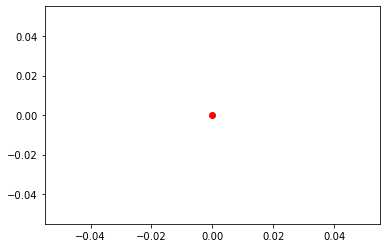

In [10]:
data = pd.read_csv('./data/overhang/overhang.csv', header = None)
arr = pd.DataFrame(data).to_numpy()
absVec = (arr[:,1]**2+arr[:,2]**2+arr[:,3]**2)**(0.5)
absVec2 = (arr[:,4]**2+arr[:,5]**2+arr[:,6]**2)**(0.5)
nof = len(absVec)

redDot, = plt.plot([0], [np.sin(0)], 'ro')
hand = Image.open('handp.png')
siz = 75

def handPlot(time, frame, left_or_right):
    if time > nof / 50:
        time = nof / 50
    pos = math.floor(time * 50)
    if pos == 0:
        return frame
    
    hand_ = hand.resize((siz,siz))
    plt.clf()
    fig = plt.gcf()
    ax = plt.gca()
    plt.plot([0],[0])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    redDot.set_data(pos, pos)
    plt.tight_layout()

    if left_or_right:
        hand_data = absVec
    else:
        hand_data = absVec2
        
    fig_width = frame.shape[1] / 80 / 4
    fig_height = frame.shape[0] / 80 / 4
    fig.set_size_inches(fig_width, fig_height)
    fig.figimage(hand.resize((math.floor(siz*hand_data[pos]),math.floor(siz*hand_data[pos]))),
                              xo=(fig_width * 80 / 2)-math.floor(siz*hand_data[pos]/2),
                              yo=(fig_height * 80 / 2)-math.floor(siz*hand_data[pos]/2),
                              alpha=0.5+(0.2*hand_data[pos]),
                              cmap=plt.gray())
    
    plt.savefig('over_hand_plot.png', transparent=True, dpi=80)

    overlay = cv2.imread('over_hand_plot.png', cv2.IMREAD_UNCHANGED)

    new_frame = frame

    if left_or_right:
        x_offset = int(2 * frame.shape[1] / 4)
    else:
        x_offset = int(3 * frame.shape[1] / 4)

    y_offset = int(3 * frame.shape[0] / 4)
    y1, y2 = y_offset, y_offset + overlay.shape[0]
    x1, x2 = x_offset, x_offset + overlay.shape[1]
    alpha_o = overlay[:, :, 3] / 255.0
    alpha_n = 1.0 - alpha_o

    for c in range(0, 3):
        new_frame[y1:y2, x1:x2, c] = (alpha_o * overlay[:, :, c] +
                                  alpha_n * new_frame[y1:y2, x1:x2, c])

    return new_frame

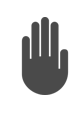

In [11]:
overlayGraph('./data/overhang/Overhang.mp4', 'overhang_overlay.mp4', 8, 10000, 30, 8)